# Azure AutoML for Images - Flowers Classification - SDK v2

# 1. Connect to Azure Machine Learning Workspace

The [workspace](https://docs.microsoft.com/en-us/azure/machine-learning/concept-workspace) is the top-level resource for Azure Machine Learning, providing a centralized place to work with all the artifacts you create when you use Azure Machine Learning. In this section we will connect to the workspace in which the job will be run.

## 1.1. Import the required libraries

In [1]:
import base64
import datetime
import json
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import os
import pandas as pd
import platform
import psutil
import sys
import time

from io import BytesIO
from IPython.display import Image
from mlflow.tracking.client import MlflowClient
from PIL import Image as PILImage

from azure.ai.ml import automl
from azure.ai.ml import Input
from azure.ai.ml import MLClient
from azure.ai.ml.automl import SearchSpace, ClassificationPrimaryMetrics
from azure.ai.ml.constants import AssetTypes, InputOutputModes
from azure.ai.ml.entities import AmlCompute
from azure.ai.ml.entities import Data
from azure.ai.ml.entities import OnlineRequestSettings
from azure.core.exceptions import ResourceNotFoundError
from azure.identity import DefaultAzureCredential

from azure.ai.ml.sweep import (
    Choice,
    Choice,
    Uniform,
    BanditPolicy,
)

In [2]:
sys.version

'3.10.6 (main, Oct 24 2022, 16:07:47) [GCC 11.2.0]'

In [3]:
print('Uname:', platform.uname())
print('Machine :', platform.machine())
print('Node :', platform.node())
print('Processor :', platform.processor())
print('Release :', platform.release())
print()
print('System :', platform.system())
print('Version :', platform.version())
print('Platform :', platform.platform())
print("Python version: ", sys.version)
print("Python version info: ", sys.version_info)
psutil.virtual_memory()
print()
print(f"Number of physical cores: {psutil.cpu_count(logical=False)}")
print(f"Number of logical cores: {psutil.cpu_count(logical=True)}")
print(f"Current CPU frequency: {psutil.cpu_freq().current}")
print(f"Min CPU frequency: {psutil.cpu_freq().min}")
print(f"Max CPU frequency: {psutil.cpu_freq().max}")

Uname: uname_result(system='Linux', node='standardds11cpu', release='5.15.0-1022-azure', version='#27~20.04.1-Ubuntu SMP Mon Oct 17 02:03:50 UTC 2022', machine='x86_64')
Machine : x86_64
Node : standardds11cpu
Processor : x86_64
Release : 5.15.0-1022-azure

System : Linux
Version : #27~20.04.1-Ubuntu SMP Mon Oct 17 02:03:50 UTC 2022
Platform : Linux-5.15.0-1022-azure-x86_64-with-glibc2.31
Python version:  3.10.6 (main, Oct 24 2022, 16:07:47) [GCC 11.2.0]
Python version info:  sys.version_info(major=3, minor=10, micro=6, releaselevel='final', serial=0)

Number of physical cores: 2
Number of logical cores: 2
Current CPU frequency: 2593.904
Min CPU frequency: 0.0
Max CPU frequency: 0.0


## 1.2. Configure workspace details and get a handle to the workspace

To connect to a workspace, we need identifier parameters - a subscription, resource group and workspace name. We will use these details in the `MLClient` from `azure.ai.ml` to get a handle to the required Azure Machine Learning workspace.

In [4]:
sid = "xxxxxxxx"  # Azuresubscription
rg = "xxxxxxx"  # Azure ML workspace resource group
ws = "xxxxx"  # Azure ML workspace

In [5]:
credential = DefaultAzureCredential()
ml_client = None

try:
    ml_client = MLClient.from_config(credential)

except Exception as ex:
    print(ex)
    subscription_id = sid
    resource_group = rg
    workspace = ws
    ml_client = MLClient(credential,
                         subscription_id,
                         resource_group,
                         workspace)

Found the config file in: /config.json


# 2. MLTable with input Training Data

In order to generate models for computer vision tasks with automated machine learning, you need to bring labeled image data as input for model training in the form of an MLTable. You can create an MLTable from labeled training data in JSONL format. If your labeled training data is in a different format (like, pascal VOC or COCO), you can use a conversion script to first convert it to JSONL, and then create an MLTable. Alternatively, you can use Azure Machine Learning's [data labeling tool](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-create-image-labeling-projects) to manually label images, and export the labeled data to use for training your AutoML model.

## 2.1. Download the Data
We first download and unzip the data locally. By default, the data would be downloaded in `./data` folder in current directory. 
If you prefer to download the data at a different location, update it in `dataset_parent_dir = ...` in the next cell.

In [6]:
home_dir = os.getcwd()

# Change to a different location if you prefer
dataset_parent_dir = "./classification_images"

# create data folder if it doesnt exist.
os.makedirs(dataset_parent_dir, exist_ok=True)

# download data
download_url = "https://www.dropbox.com/s/q05d7smirnc4hmz/flowers_classification.zip"
zip_file = os.path.split(download_url)[-1]
   
# Extract current dataset name from dataset url
dataset_name = zip_file.split(".")[0]  # just the name of the zip file without the extension

# Get dataset path for later use
dataset_dir = os.path.join(dataset_parent_dir, dataset_name) #  full directory
os.makedirs(dataset_dir, exist_ok=True)

# Get the data zip file path
data_file = os.path.join(dataset_parent_dir, dataset_name, f"{dataset_name}.zip")  # full zip location

# Download the dataset
os.chdir(dataset_dir)
!wget $download_url

# Unzip
!unzip -qq $zip_file

# Deleting the file
os.remove(zip_file)

os.chdir(home_dir)

--2023-02-07 14:10:11--  https://www.dropbox.com/s/q05d7smirnc4hmz/flowers_classification.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6021:18::a27d:4112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/q05d7smirnc4hmz/flowers_classification.zip [following]
--2023-02-07 14:10:12--  https://www.dropbox.com/s/raw/q05d7smirnc4hmz/flowers_classification.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucea97d8865ab5d7d4e7019bf1b9.dl.dropboxusercontent.com/cd/0/inline/B2DxZNIx7HP0Y4dvuoew-rBBA0xeQ22_mis484G7L0rTiuBJrZ4xUPXJonaZ5kEXybqFD-Y14y0BeHVUl75b26xqGoX7uUYJznaNPK6d8cWepxZpbIDxpHuTa1lWB5xQi9jSkINOwlqGzooIBwDUY3RJgSlrOGCpnbgrICkE_Avi_Q/file# [following]
--2023-02-07 14:10:12--  https://ucea97d8865ab5d7d4e7019bf1b9.dl.dropboxusercontent.com/cd/0/inline/B2DxZNIx7HP0Y4dvuoew-rBBA0xeQ22_mis

In [7]:
dataset_dir, dataset_name, data_file

('./classification_images/flowers_classification',
 'flowers_classification',
 './classification_images/flowers_classification/flowers_classification.zip')

This is a sample image from this dataset:

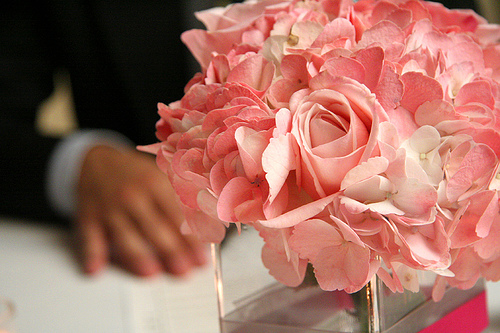

In [8]:
sample_image = os.path.join(dataset_dir, "roses", "roses_1.jpg")
Image(filename=sample_image)

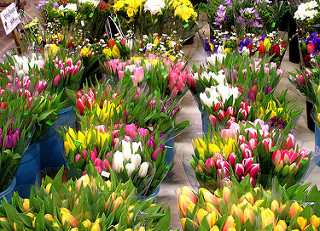

In [9]:
sample_image = os.path.join(dataset_dir, "tulips", "tulips_1.jpg")
Image(filename=sample_image)

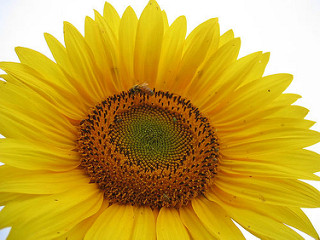

In [10]:
sample_image = os.path.join(dataset_dir, "sunflowers", "sunflowers_1.jpg")
Image(filename=sample_image)

## 2.2. Upload the images to Datastore through an AML Data asset (URI Folder)

In [11]:
# Uploading image files by creating a 'data asset URI FOLDER'
my_data = Data(
    path=dataset_dir,
    type=AssetTypes.URI_FOLDER,
    description="Flowers images for images classification",
    name="Flowers-images",
)

uri_folder_data_asset = ml_client.data.create_or_update(my_data)

print(uri_folder_data_asset)
print()
print("Path to folder in Blob Storage:")
print(uri_folder_data_asset.path)

Data({'skip_validation': False, 'mltable_schema_url': None, 'referenced_uris': None, 'type': 'uri_folder', 'is_anonymous': False, 'auto_increment_version': False, 'name': 'Flowers-images', 'description': 'Flowers images for images classification', 'tags': {}, 'properties': {}, 'id': '/subscriptions/b8acd8e6-3841-4717-8469-82e36dad9ae5/resourceGroups/azureml-rg/providers/Microsoft.MachineLearningServices/workspaces/azureml/data/Flowers-images/versions/5', 'Resource__source_path': None, 'base_path': '/mnt/batch/tasks/shared/LS_root/mounts/clusters/standardds11cpu/code/Users/seretkow/AutoML_for_images_sdkv2/classification', 'creation_context': <azure.ai.ml.entities._system_data.SystemData object at 0x7fc7d6f06fe0>, 'serialize': <msrest.serialization.Serializer object at 0x7fc7d6f07cd0>, 'version': '5', 'latest_version': None, 'path': 'azureml://subscriptions/b8acd8e6-3841-4717-8469-82e36dad9ae5/resourcegroups/azureml-rg/workspaces/azureml/datastores/workspaceblobstore/paths/LocalUpload/72

## 2.3. Convert the downloaded data to JSONL


This is the most common data format for multiclass image classification. Each folder title corresponds to the image label for the images contained inside. 

For documentation on preparing the datasets beyond this notebook, please refer to the [documentation on how to prepare datasets](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-prepare-datasets-for-automl-images).

In order to use this data to create an AzureML MLTable, we first need to convert it to the required JSONL format. The following script is creating two `.jsonl` files (one for training and one for validation) in the corresponding MLTable folder. The train / validation ratio corresponds to 20% of the data going into the validation file. For further details on jsonl file used for image classification task in automated ml, please refer to the [data schema documentation for multi-class image classification task](https://learn.microsoft.com/en-us/azure/machine-learning/reference-automl-images-schema#image-classification-binarymulti-class).

In [12]:
train_validation_ratio = 5

# We'll copy each JSONL file within its related MLTable folder
training_mltable_path = os.path.join(dataset_parent_dir, "training-mltable-folder")
validation_mltable_path = os.path.join(dataset_parent_dir, "validation-mltable-folder")

# First, let's create the folders if they don't exist
os.makedirs(training_mltable_path, exist_ok=True)
os.makedirs(validation_mltable_path, exist_ok=True)

# Path to the training and validation files
train_annotations_file = os.path.join(training_mltable_path, "train_annotations.jsonl")
validation_annotations_file = os.path.join(
    validation_mltable_path, "validation_annotations.jsonl"
)

# Baseline of json line dictionary
json_line_sample = {
    "image_url": uri_folder_data_asset.path,
    "label": "",
}

index = 0

# Scan each sub directary and generate a jsonl line per image, distributed on train and valid JSONL files
with open(train_annotations_file, "w") as train_f:
    with open(validation_annotations_file, "w") as validation_f:
        for class_name in os.listdir(dataset_dir):
            sub_dir = os.path.join(dataset_dir, class_name)
            if not os.path.isdir(sub_dir):
                continue

            # Scan each sub directary
            print(f"Parsing {sub_dir}")
            for image in os.listdir(sub_dir):
                json_line = dict(json_line_sample)
                json_line["image_url"] += f"{class_name}/{image}"
                json_line["label"] = class_name

                if index % train_validation_ratio == 0:
                    # validation annotation
                    validation_f.write(json.dumps(json_line) + "\n")
                else:
                    # train annotation
                    train_f.write(json.dumps(json_line) + "\n")

                index += 1

Parsing ./classification_images/flowers_classification/daisy
Parsing ./classification_images/flowers_classification/dandelion
Parsing ./classification_images/flowers_classification/roses
Parsing ./classification_images/flowers_classification/sunflowers
Parsing ./classification_images/flowers_classification/tulips


## 2.4. Create MLTable data input

Create MLTable data input using the jsonl files created above.

For documentation on creating your own MLTable assets for jobs beyond this notebook, please refer to below resources
- [MLTable YAML Schema](https://learn.microsoft.com/en-us/azure/machine-learning/reference-yaml-mltable) - covers how to write MLTable YAML, which is required for each MLTable asset.
- [Create MLTable data asset](https://learn.microsoft.com/en-us/azure/machine-learning/how-to-create-data-assets?tabs=Python-SDK#create-a-mltable-data-asset) - covers how to create MLTable data asset. 

In [13]:
def create_ml_table_file(filename):
    """Create ML Table definition"""

    return ("paths:\n"
            "  - file: ./{0}\n"
            "transformations:\n"
            "  - read_json_lines:\n"
            "        encoding: utf8\n"
            "        invalid_lines: error\n"
            "        include_path_column: false\n"
            "  - convert_column_types:\n"
            "      - columns: image_url\n"
            "        column_type: stream_info").format(filename)


def save_ml_table_file(output_path, mltable_file_contents):
    with open(os.path.join(output_path, "MLTable"), "w") as f:
        f.write(mltable_file_contents)


# Create and save train mltable
train_mltable_file_contents = create_ml_table_file(
    os.path.basename(train_annotations_file))
save_ml_table_file(training_mltable_path, train_mltable_file_contents)

# Create and save validation mltable
validation_mltable_file_contents = create_ml_table_file(
    os.path.basename(validation_annotations_file))
save_ml_table_file(validation_mltable_path, validation_mltable_file_contents)

In [14]:
# Training MLTable defined locally, with local data to be uploaded
my_training_data_input = Input(type=AssetTypes.MLTABLE,
                               path=training_mltable_path)

# Validation MLTable defined locally, with local data to be uploaded
my_validation_data_input = Input(type=AssetTypes.MLTABLE,
                                 path=validation_mltable_path)

# WITH REMOTE PATH: If available already in the cloud/workspace-blob-store
# my_training_data_input = Input(type=AssetTypes.MLTABLE, path="azureml://datastores/workspaceblobstore/paths/vision-classification/train")
# my_validation_data_input = Input(type=AssetTypes.MLTABLE, path="azureml://datastores/workspaceblobstore/paths/vision-classification/valid")

# 3. Compute target setup

You will need to provide a [Compute Target](https://docs.microsoft.com/en-us/azure/machine-learning/concept-azure-machine-learning-architecture#computes) that will be used for your AutoML model training. AutoML models for image tasks require [GPU SKUs](https://docs.microsoft.com/en-us/azure/virtual-machines/sizes-gpu) such as the ones from the NC, NCv2, NCv3, ND, NDv2 and NCasT4 series. We recommend using the NCsv3-series (with v100 GPUs) for faster training. Using a compute target with a multi-GPU VM SKU will leverage the multiple GPUs to speed up training. Additionally, setting up a compute target with multiple nodes will allow for faster model training by leveraging parallelism, when tuning hyperparameters for your model.


In [15]:
compute_name = "gpu-cluster-nc6"

try:
    _ = ml_client.compute.get(compute_name)
    print("Found existing compute target.")

except ResourceNotFoundError:
    print("Creating a new compute target...")
    compute_config = AmlCompute(
        name=compute_name,
        type="amlcompute",
        size="Standard_NC6",
        idle_time_before_scale_down=120,
        min_instances=0,
        max_instances=4,
    )
    
    ml_client.begin_create_or_update(compute_config).result()

Found existing compute target.


# 4. Configure and run the AutoML for Images Classification-MultiClass training job

AutoML allows you to easily train models for Image Classification, Object Detection & Instance Segmentation on your image data. You can control the model algorithm and hyperparameters to be used, perform a sweep over a manually specified hyperparameter space, or the system can automatically perform a hyperparameter sweep for you.


## 4.1. Automatic hyperparameter sweeping for your models (AutoMode)

When using AutoML for Images, we can perform an automatic hyperparameter sweep to find the optimal model (we call this functionality AutoMode). The system will choose a model architecture and values for the learning_rate, number_of_epochs, training_batch_size, etc. based on the number of runs. There is no need to specify the hyperparameter search space, sampling method or early termination policy. A number of runs between 10 and 20 will likely work well on many datasets.

AutoMode is triggered by setting `max_trials` to a value greater than 1 in limits and by omitting the hyperparameter space, sampling method and termination policy.

The following functions configure AutoML image jobs for automatic sweeps:
### image_classification() function parameters:
The `image_classification()` factory function allows user to configure the training job.

- `compute` - The compute on which the AutoML job will run. In this example we are using a compute called 'gpu-cluster' present in the workspace. You can replace it any other compute in the workspace.
- `experiment_name` - The name of the experiment. An experiment is like a folder with multiple runs in Azure ML Workspace that should be related to the same logical machine learning experiment.
- `name` - The name of the Job/Run. This is an optional property. If not specified, a random name will be generated.
- `primary_metric` - The metric that AutoML will optimize for model selection.
- `target_column_name` - The name of the column to target for predictions. It must always be specified. This parameter is applicable to 'training_data' and 'validation_data'.
- `training_data` - The data to be used for training. It should contain both training feature columns and a target column. Optionally, this data can be split for segregating a validation or test dataset. 
You can use a registered MLTable in the workspace using the format '<mltable_name>:<version>' OR you can use a local file or folder as a MLTable. For e.g Input(mltable='my_mltable:1') OR Input(mltable=MLTable(local_path="./data"))
The parameter `training_data` must always be provided.

### set_limits() function parameters:
This is an optional configuration method to configure limits parameters such as timeouts.

- `max_trials` - Parameter for maximum number of configurations to sweep. Must be an integer between 1 and 1000. When exploring just the default hyperparameters for a given model algorithm, set this parameter to 1. Default value is 1.
- `max_concurrent_trials` - Maximum number of runs that can run concurrently. If not specified, all runs launch in parallel. If specified, must be an integer between 1 and 100.  Default value is 1.
    NOTE: The number of concurrent runs is gated on the resources available in the specified compute target. Ensure that the compute target has the available resources for the desired concurrency.



In [16]:
# set up experiment name
exp_name = "Flowers-Classification-AutoML"

In [17]:
# Create the AutoML job with the related factory-function.
image_classification_job = automl.image_classification(
    compute=compute_name,
    # name="dpv2-image-classification-job-02",
    experiment_name=exp_name,
    training_data=my_training_data_input,
    validation_data=my_validation_data_input,
    target_column_name="label",
    primary_metric="accuracy",
    tags={"topic": "Flowers Classification"},
)

image_classification_job.set_limits(
    max_trials=10,
    max_concurrent_trials=2,
)

### Submitting an AutoML job for Computer Vision tasks
Once you've configured your job, you can submit it as a job in the workspace in order to train a vision model using your training dataset.

In [18]:
# Submit the AutoML job
returned_job = ml_client.jobs.create_or_update(
    image_classification_job)  # submit the job to the backend

print(f"Created job: {returned_job}")

Created job: ImageClassificationJob({'log_verbosity': <LogVerbosity.INFO: 'Info'>, 'target_column_name': 'label', 'validation_data_size': None, 'task_type': <TaskType.IMAGE_CLASSIFICATION: 'ImageClassification'>, 'training_data': {'type': 'mltable', 'path': 'azureml://datastores/workspaceblobstore/paths/LocalUpload/9eace09ce66699ec99f283ae05a59a08/training-mltable-folder'}, 'validation_data': {'type': 'mltable', 'path': 'azureml://datastores/workspaceblobstore/paths/LocalUpload/6e6aa665664ac05ee13682563e840cc0/validation-mltable-folder'}, 'test_data': None, 'environment_id': None, 'environment_variables': None, 'outputs': {}, 'type': 'automl', 'status': 'NotStarted', 'log_files': None, 'name': 'amusing_pepper_qs8dghmh4z', 'description': None, 'tags': {'topic': 'Flowers Classification'}, 'properties': {}, 'id': '/subscriptions/b8acd8e6-3841-4717-8469-82e36dad9ae5/resourceGroups/azureml-rg/providers/Microsoft.MachineLearningServices/workspaces/azureml/jobs/amusing_pepper_qs8dghmh4z', 'Re

In [19]:
ml_client.jobs.stream(returned_job.name)

RunId: amusing_pepper_qs8dghmh4z
Web View: https://ml.azure.com/runs/amusing_pepper_qs8dghmh4z?wsid=/subscriptions/b8acd8e6-3841-4717-8469-82e36dad9ae5/resourcegroups/azureml-rg/workspaces/azureml

Execution Summary
RunId: amusing_pepper_qs8dghmh4z
Web View: https://ml.azure.com/runs/amusing_pepper_qs8dghmh4z?wsid=/subscriptions/b8acd8e6-3841-4717-8469-82e36dad9ae5/resourcegroups/azureml-rg/workspaces/azureml



## 4.2. Individual runs

If AutoMode does not meet your needs, you can launch individual runs to explore model algorithms; we provide sensible default hyperparameters for each algorithm. You can also launch individual runs for the same model algorithm and different hyperparameter combinations. The model algorithm is specified using the model_name parameter. Please refer to the [documentation](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-auto-train-image-models?tabs=CLI-v2#configure-model-algorithms-and-hyperparameters) for the list of supported model algorithms.

The following function can be used to configure AutoML jobs for individual runs:
### set_training_parameters() function parameters:
This is an optional configuration method to configure fixed settings or parameters that don't change during the parameter space sweep. Some of the key parameters of this function are:

- `model_name` - The name of the ML algorithm that we want to use in training job. Please refer to this [documentation](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-auto-train-image-models?tabs=CLI-v2#supported-model-algorithms) for supported model algorithm.
- `number_of_epochs` - The number of training epochs. It must be positive integer (default value is 15).
- `layers_to_freeze` - The number of layers to freeze in model for transfer learning. It must be a positive integer (default value is 0).
- `early_stopping` - It enable early stopping logic during training, It must be boolean value (default is True).   
- `optimizer` - Type of optimizer to use in training. It must be either sgd, adam, adamw (default is sgd).
- `distributed` - It enable distributed training if compute target contain multiple GPUs. It must be boolean value (default is True).
    
If you wish to use the default hyperparameter values for a given algorithm (say `vitb16r224`), you can specify the job for your AutoML Image runs as follows:

In [20]:
# Create the AutoML job with the related factory-function
image_classification_job = automl.image_classification(
    compute=compute_name,
    experiment_name=exp_name,
    training_data=my_training_data_input,
    validation_data=my_validation_data_input,
    target_column_name="label",
)

image_classification_job.set_limits(timeout_minutes=60)
image_classification_job.set_training_parameters(model_name="vitb16r224")

In [21]:
# Submit the AutoML job
returned_job = ml_client.jobs.create_or_update(image_classification_job)

print(f"Created job: {returned_job}")

Created job: ImageClassificationJob({'log_verbosity': <LogVerbosity.INFO: 'Info'>, 'target_column_name': 'label', 'validation_data_size': None, 'task_type': <TaskType.IMAGE_CLASSIFICATION: 'ImageClassification'>, 'training_data': {'type': 'mltable', 'path': 'azureml://datastores/workspaceblobstore/paths/LocalUpload/9eace09ce66699ec99f283ae05a59a08/training-mltable-folder'}, 'validation_data': {'type': 'mltable', 'path': 'azureml://datastores/workspaceblobstore/paths/LocalUpload/6e6aa665664ac05ee13682563e840cc0/validation-mltable-folder'}, 'test_data': None, 'environment_id': None, 'environment_variables': None, 'outputs': {}, 'type': 'automl', 'status': 'NotStarted', 'log_files': None, 'name': 'mighty_book_b13y23mgq2', 'description': None, 'tags': {}, 'properties': {}, 'id': '/subscriptions/b8acd8e6-3841-4717-8469-82e36dad9ae5/resourceGroups/azureml-rg/providers/Microsoft.MachineLearningServices/workspaces/azureml/jobs/mighty_book_b13y23mgq2', 'Resource__source_path': None, 'base_path'

In [22]:
ml_client.jobs.stream(returned_job.name)

RunId: mighty_book_b13y23mgq2
Web View: https://ml.azure.com/runs/mighty_book_b13y23mgq2?wsid=/subscriptions/b8acd8e6-3841-4717-8469-82e36dad9ae5/resourcegroups/azureml-rg/workspaces/azureml

Execution Summary
RunId: mighty_book_b13y23mgq2
Web View: https://ml.azure.com/runs/mighty_book_b13y23mgq2?wsid=/subscriptions/b8acd8e6-3841-4717-8469-82e36dad9ae5/resourcegroups/azureml-rg/workspaces/azureml



## 4.3. Manual hyperparameter sweeping for your model

When using AutoML for Images, we can perform a hyperparameter sweep over a defined parameter space to find the optimal model. In this example, we sweep over the hyperparameters for `seresnext`, `resnet50`, `vitb16r224`, and `vits16r224` models, choosing from a range of values for learning_rate, number_of_epochs, layers_to_freeze, etc., to generate a model with the optimal 'accuracy'. If hyperparameter values are not specified, then default values are used for the specified algorithm.

set_sweep function is used to configure the sweep settings:
### set_sweep() parameters:
- `sampling_algorithm` - Sampling method to use for sweeping over the defined parameter space. Please refer to this [documentation](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-auto-train-image-models?tabs=SDK-v2#sampling-methods-for-the-sweep) for list of supported sampling methods.
- `early_termination` - Early termination policy to end poorly performing runs. If no termination policy is specified, all configurations are run to completion. Please refer to this [documentation](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-auto-train-image-models?tabs=SDK-v2#early-termination-policies) for supported early termination policies.

We use Random Sampling to pick samples from this parameter space and try a total of 10 iterations with these different samples, running 2 iterations at a time on our compute target. Please note that the more parameters the space has, the more iterations you need to find optimal models.

We leverage the Bandit early termination policy which will terminate poor performing configs (those that are not within 20% slack of the best performing config), thus significantly saving compute resources.

For more details on model and hyperparameter sweeping, please refer to the [documentation](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-tune-hyperparameters).

In [23]:
# Create the AutoML job with the related factory-function.
image_classification_job = automl.image_classification(
    compute=compute_name,
    experiment_name=exp_name,
    training_data=my_training_data_input,
    validation_data=my_validation_data_input,
    target_column_name="label",
    primary_metric=ClassificationPrimaryMetrics.ACCURACY,
    tags={"tuning": "yes"},
)

image_classification_job.set_limits(
    timeout_minutes=60,
    max_trials=10,
    max_concurrent_trials=2,
)

image_classification_job.extend_search_space([
    SearchSpace(
        model_name=Choice(["vitb16r224", "vits16r224"]),
        learning_rate=Uniform(0.001, 0.01),
        number_of_epochs=Choice([15, 30]),
    ),
    SearchSpace(
        model_name=Choice(["seresnext", "resnet50"]),
        learning_rate=Uniform(0.001, 0.01),
        layers_to_freeze=Choice([0, 2]),
    ),
])

image_classification_job.set_sweep(
    sampling_algorithm="Random",
    early_termination=BanditPolicy(evaluation_interval=2,
                                   slack_factor=0.2,
                                   delay_evaluation=6),
)

In [24]:
# Submit the AutoML job
returned_job = ml_client.jobs.create_or_update(
    image_classification_job)  # submit the job to the backend

print(f"Created job: {returned_job}")

Created job: ImageClassificationJob({'log_verbosity': <LogVerbosity.INFO: 'Info'>, 'target_column_name': 'label', 'validation_data_size': None, 'task_type': <TaskType.IMAGE_CLASSIFICATION: 'ImageClassification'>, 'training_data': {'type': 'mltable', 'path': 'azureml://datastores/workspaceblobstore/paths/LocalUpload/9eace09ce66699ec99f283ae05a59a08/training-mltable-folder'}, 'validation_data': {'type': 'mltable', 'path': 'azureml://datastores/workspaceblobstore/paths/LocalUpload/6e6aa665664ac05ee13682563e840cc0/validation-mltable-folder'}, 'test_data': None, 'environment_id': None, 'environment_variables': None, 'outputs': {}, 'type': 'automl', 'status': 'NotStarted', 'log_files': None, 'name': 'placid_hair_d56nvgyj21', 'description': None, 'tags': {'tuning': 'yes'}, 'properties': {}, 'id': '/subscriptions/b8acd8e6-3841-4717-8469-82e36dad9ae5/resourceGroups/azureml-rg/providers/Microsoft.MachineLearningServices/workspaces/azureml/jobs/placid_hair_d56nvgyj21', 'Resource__source_path': No

In [25]:
ml_client.jobs.stream(returned_job.name)

RunId: placid_hair_d56nvgyj21
Web View: https://ml.azure.com/runs/placid_hair_d56nvgyj21?wsid=/subscriptions/b8acd8e6-3841-4717-8469-82e36dad9ae5/resourcegroups/azureml-rg/workspaces/azureml

Execution Summary
RunId: placid_hair_d56nvgyj21
Web View: https://ml.azure.com/runs/placid_hair_d56nvgyj21?wsid=/subscriptions/b8acd8e6-3841-4717-8469-82e36dad9ae5/resourcegroups/azureml-rg/workspaces/azureml



When doing a hyperparameter sweep, it can be useful to visualize the different configurations that were tried using the HyperDrive UI. You can navigate to this UI by going to the 'Child jobs' tab in the UI of the main automl image job from above, which is the HyperDrive parent run. Then you can go into the 'Trials' tab of this HyperDrive parent run. Alternatively, here below you can see directly the HyperDrive parent run and navigate to its 'Trials' tab:

In [26]:
hd_job = ml_client.jobs.get(returned_job.name + "_HD")
hd_job

Experiment,Name,Type,Status,Details Page
Flowers-Classification-AutoML,placid_hair_d56nvgyj21_HD,sweep,Completed,Link to Azure Machine Learning studio


# 5. Retrieve the Best Trial (Best Model's trial/run)
Use the MLFLowClient to access the results (such as Models, Artifacts, Metrics) of a previously completed AutoML Trial.

## Initialize MLFlow Client

The models and artifacts that are produced by AutoML can be accessed via the MLFlow interface.
Initialize the MLFlow client here, and set the backend as Azure ML, via. the MLFlow Client.

IMPORTANT, you need to have installed the latest MLFlow packages with:

    pip install azureml-mlflow

    pip install mlflow

In [27]:
# Obtain the tracking URL from MLClient
MLFLOW_TRACKING_URI = ml_client.workspaces.get(
    name=ml_client.workspace_name).mlflow_tracking_uri

print(MLFLOW_TRACKING_URI)

azureml://westeurope.api.azureml.ms/mlflow/v1.0/subscriptions/b8acd8e6-3841-4717-8469-82e36dad9ae5/resourceGroups/azureml-rg/providers/Microsoft.MachineLearningServices/workspaces/azureml


In [28]:
# Set the MLFLOW TRACKING URI
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)

print(f"\nCurrent tracking uri: {mlflow.get_tracking_uri()}")


Current tracking uri: azureml://westeurope.api.azureml.ms/mlflow/v1.0/subscriptions/b8acd8e6-3841-4717-8469-82e36dad9ae5/resourceGroups/azureml-rg/providers/Microsoft.MachineLearningServices/workspaces/azureml


In [29]:
# Initialize MLFlow client
mlflow_client = MlflowClient()

### Get the AutoML parent Job

In [30]:
job_name = returned_job.name

# Example if providing an specific Job name/ID
# job_name = "salmon_camel_5sdf05xvb3"

# Get the parent run
mlflow_parent_run = mlflow_client.get_run(job_name)

print("Parent Run: ")
print(mlflow_parent_run)

Parent Run: 
<Run: data=<RunData: metrics={'AUC_macro': 1.0,
 'AUC_micro': 0.99972,
 'AUC_weighted': 1.0,
 'accuracy': 0.98,
 'accuracy_train': 0.96742,
 'average_precision_score_macro': 1.0,
 'average_precision_score_micro': 0.99891,
 'average_precision_score_weighted': 1.0,
 'f1_score_macro': 0.97972,
 'f1_score_micro': 0.98,
 'f1_score_weighted': 0.97972,
 'log_loss': 0.05533,
 'log_loss_train': 0.10787,
 'precision_score_macro': 0.98095,
 'precision_score_micro': 0.98,
 'precision_score_weighted': 0.98095,
 'recall_score_macro': 0.98,
 'recall_score_micro': 0.98,
 'recall_score_weighted': 0.98}, params={}, tags={'_azureml.ComputeTargetType': 'STANDARD_NC6',
 'automl_best_child_run_id': 'placid_hair_d56nvgyj21_HD_0',
 'fit_time': '',
 'iteration': '',
 'mlflow.rootRunId': 'placid_hair_d56nvgyj21',
 'mlflow.runName': 'placid_hair_d56nvgyj21',
 'mlflow.user': 'Serge Retkowsky',
 'model_explain_run': 'best_run',
 'pipeline_id_000': 'UnkownPipelineId',
 'predicted_cost': '',
 'run_algor

In [31]:
# Print parent run tags. 'automl_best_child_run_id' tag should be there.
print(mlflow_parent_run.data.tags.keys())

dict_keys(['tuning', 'model_explain_run', '_azureml.ComputeTargetType', 'pipeline_id_000', 'score', 'predicted_cost', 'fit_time', 'training_percent', 'iteration', 'run_preprocessor', 'run_algorithm', 'automl_best_child_run_id', 'mlflow.rootRunId', 'mlflow.runName', 'mlflow.user'])


### Get the AutoML best child run

In [32]:
# Get the best model's child run
best_child_run_id = mlflow_parent_run.data.tags["automl_best_child_run_id"]
print(f"Found best child run id: {best_child_run_id}")

best_run = mlflow_client.get_run(best_child_run_id)
print("\nBest child run:\n")
print(best_run)

Found best child run id: placid_hair_d56nvgyj21_HD_0

Best child run:

<Run: data=<RunData: metrics={'AUC_macro': 1.0,
 'AUC_micro': 0.99972,
 'AUC_weighted': 1.0,
 'accuracy': 0.98,
 'accuracy_train': 0.96742,
 'average_precision_score_macro': 1.0,
 'average_precision_score_micro': 0.99891,
 'average_precision_score_weighted': 1.0,
 'f1_score_macro': 0.97972,
 'f1_score_micro': 0.98,
 'f1_score_weighted': 0.97972,
 'log_loss': 0.05533,
 'log_loss_train': 0.10787,
 'precision_score_macro': 0.98095,
 'precision_score_micro': 0.98,
 'precision_score_weighted': 0.98095,
 'recall_score_macro': 0.98,
 'recall_score_micro': 0.98,
 'recall_score_weighted': 0.98}, params={}, tags={'hyperparameters': '{"model": {"learning_rate": 0.008565768191623663, '
                    '"model_name": "vitb16r224", "number_of_epochs": 30}}',
 'mlflow.parentRunId': 'placid_hair_d56nvgyj21_HD',
 'mlflow.rootRunId': 'placid_hair_d56nvgyj21',
 'mlflow.runName': 'helpful_office_7w3g03vg',
 'mlflow.source.name': 'h

## Get best model run's metrics
Access the results (such as Models, Artifacts, Metrics) of a previously completed AutoML Run.

In [33]:
pd.DataFrame(best_run.data.metrics, index=[0]).T

,0
accuracy_train,0.96742
log_loss_train,0.10787
log_loss,0.05533
average_precision_score_weighted,1.00000
average_precision_score_micro,0.99891
f1_score_macro,0.97972
recall_score_micro,0.98000
precision_score_micro,0.98000
accuracy,0.98000
recall_score_macro,0.98000


## Download the best model locally
Access the results (such as Models, Artifacts, Metrics) of a previously completed AutoML Run.

In [34]:
# Create local folder
local_dir = "./classification_model"
os.makedirs(local_dir, exist_ok=True)

In [35]:
# Download run's outputs
local_path = mlflow_client.download_artifacts(best_run.info.run_id, 
                                              "outputs",
                                              local_dir)

print(f"Artifacts downloaded in: {local_path}")
os.listdir(local_path)

Artifacts downloaded in: /mnt/batch/tasks/shared/LS_root/mounts/clusters/standardds11cpu/code/Users/seretkow/AutoML_for_images_sdkv2/classification/classification_model/outputs


['conda_env_v_1_0_0.yml',
 'generated_code',
 'mlflow-model',
 'model.pt',
 'run_id.txt',
 'scoring_file_v_1_0_0.py']

In [36]:
# Download run's artifacts
local_path = mlflow_client.download_artifacts(best_run.info.run_id, 
                                              "train_artifacts",
                                              local_dir)

print(f"Train artifacts downloaded in: {local_path}")
os.listdir(local_path)

Train artifacts downloaded in: /mnt/batch/tasks/shared/LS_root/mounts/clusters/standardds11cpu/code/Users/seretkow/AutoML_for_images_sdkv2/classification/classification_model/train_artifacts


['featurize_script.py',
 'labels.json',
 'model.onnx',
 'model.pt',
 'score_script.py',
 'train_df.csv',
 'val_df.csv']

In [37]:
!ls $local_dir/outputs -lh

total 655M
-rwxrwxrwx 1 root root  657 Feb  7 18:09 conda_env_v_1_0_0.yml
drwxrwxrwx 2 root root    0 Feb  7 18:09 generated_code
drwxrwxrwx 2 root root    0 Feb  7 18:09 mlflow-model
-rwxrwxrwx 1 root root 655M Feb  7 18:09 model.pt
-rwxrwxrwx 1 root root   27 Feb  7 18:09 run_id.txt
-rwxrwxrwx 1 root root 2.1K Feb  7 18:09 scoring_file_v_1_0_0.py


In [38]:
!ls $local_dir/train_artifacts -lh

total 982M
-rwxrwxrwx 1 root root 2.6K Feb  7 18:09 featurize_script.py
-rwxrwxrwx 1 root root   55 Feb  7 18:09 labels.json
-rwxrwxrwx 1 root root 328M Feb  7 18:09 model.onnx
-rwxrwxrwx 1 root root 655M Feb  7 18:09 model.pt
-rwxrwxrwx 1 root root 6.3K Feb  7 18:09 score_script.py
-rwxrwxrwx 1 root root 118K Feb  7 18:09 train_df.csv
-rwxrwxrwx 1 root root  30K Feb  7 18:09 val_df.csv


In [39]:
mlflow_model_dir = os.path.join(local_dir,
                                "outputs",
                                "mlflow-model")

# Show the contents of the MLFlow model folder
os.listdir(mlflow_model_dir)

# You should see a list of files such as the following:
# ['artifacts', 'conda.yaml', 'MLmodel', 'python_env.yaml', 'python_model.pkl', 'requirements.txt']

['artifacts',
 'conda.yaml',
 'MLmodel',
 'python_env.yaml',
 'python_model.pkl',
 'requirements.txt']

# 6. Register best model and deploy

## 6.1 Create managed online endpoint

In [40]:
# import required libraries
from azure.ai.ml.entities import (
    ManagedOnlineEndpoint,
    ManagedOnlineDeployment,
    Model,
    Environment,
    CodeConfiguration,
    ProbeSettings,
)

In [41]:
# Creating a unique endpoint name with current datetime to avoid conflicts
online_endpoint_name = "flowers-class" + datetime.datetime.now().strftime(
    "%m%d%H%M")

# create an online endpoint
endpoint = ManagedOnlineEndpoint(
    name=online_endpoint_name,
    description="Flowers image classification",
    auth_mode="key",
    tags={"dataset": "flowers"},
)

In [42]:
start = time.time()

ml_client.begin_create_or_update(endpoint).result()

print(f"Processing time: {((time.time() - start) / 60):.2f} minutes")

Processing time: 3.59 minutes


## 6.2 Register best model and deploy

### Register model

In [43]:
start = time.time()

model_name = "flowers-class-model"

model = Model(
    path=
    f"azureml://jobs/{best_run.info.run_id}/outputs/artifacts/outputs/mlflow-model/",
    name=model_name,
    description="Flowers image classification model",
    type=AssetTypes.MLFLOW_MODEL,
)

# for downloaded file
# model = Model(
#     path=mlflow_model_dir,
#     name=model_name,
#     description="my sample image classification multiclass model",
#     type=AssetTypes.MLFLOW_MODEL,
# )
registered_model = ml_client.models.create_or_update(model)

print(f"Processing time: {(time.time() - start):.0f} seconds")

Processing time: 2 seconds


In [44]:
registered_model.id

'/subscriptions/b8acd8e6-3841-4717-8469-82e36dad9ae5/resourceGroups/azureml-rg/providers/Microsoft.MachineLearningServices/workspaces/azureml/models/flowers-class-model/versions/3'

### Deploy

In [45]:
req_timeout = OnlineRequestSettings(request_timeout_ms=90000)

In [46]:
deployment = ManagedOnlineDeployment(
    name="flowers-mlflow-deploy",
    endpoint_name=online_endpoint_name,
    model=registered_model.id,
    # use GPU instance type like Standard_NC6s_v3 for faster explanations
    instance_type="Standard_DS3_V2",
    instance_count=1,
    request_settings=req_timeout,
    liveness_probe=ProbeSettings(
        failure_threshold=30,
        success_threshold=1,
        timeout=2,
        period=10,
        initial_delay=2000,
    ),
    readiness_probe=ProbeSettings(
        failure_threshold=10,
        success_threshold=1,
        timeout=10,
        period=10,
        initial_delay=2000,
    ),
)

In [47]:
start = time.time()

ml_client.online_deployments.begin_create_or_update(deployment).result()

print(f"Processing time: {((time.time() - start) / 60):.2f} minutes")

Check: endpoint flowers-class02071810 exists
data_collector is not a known attribute of class <class 'azure.ai.ml._restclient.v2022_02_01_preview.models._models_py3.ManagedOnlineDeployment'> and will be ignored


..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................Processing time: 40.90 minutes


In [48]:
start = time.time()

endpoint.traffic = {"flowers-mlflow-deploy": 100}
ml_client.begin_create_or_update(endpoint).result()

print(f"Processing time: {(time.time() - start):.2f} seconds")

Processing time: 33.79 seconds


### Get endpoint details

In [49]:
# Get the details for online endpoint
endpoint = ml_client.online_endpoints.get(name=online_endpoint_name)

In [50]:
# existing traffic details
print(endpoint.traffic)

# Get the scoring URI
print(endpoint.scoring_uri)

{'flowers-mlflow-deploy': 100}
https://flowers-class02071810.westeurope.inference.ml.azure.com/score


### Online Inference

In [51]:
# Download some test images
url = "https://www.dropbox.com/s/fd7pdgo1fs35x4r/flowers_test.zip"
zip_file = "flowers_test.zip"

os.chdir(dataset_dir)
!wget $url  # Download zip file
!unzip $zip_file  # Unzip
os.remove(zip_file)  # Delete
os.chdir(home_dir)

--2023-02-07 19:21:13--  https://www.dropbox.com/s/fd7pdgo1fs35x4r/flowers_test.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.66.18, 2620:100:6021:18::a27d:4112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.66.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/fd7pdgo1fs35x4r/flowers_test.zip [following]
--2023-02-07 19:21:14--  https://www.dropbox.com/s/raw/fd7pdgo1fs35x4r/flowers_test.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucc4e19cdcbe74987917559183cb.dl.dropboxusercontent.com/cd/0/inline/B2AbCkHsldxZKY1CK_YdSSgUJZilztwf1Ho9t7H809PVRd9wtTJbRT_bfQj0rrYf8PzlCjsnxJzCv3fkONEtV1W-oa6TUSd4vbwhswr0_T2E19O2vFGUssPN-XcfG7ZM-NT98hrp6j2C-ixL09bxyD5hg6qFdXZ3xyPkyiMP3JHOgw/file# [following]
--2023-02-07 19:21:14--  https://ucc4e19cdcbe74987917559183cb.dl.dropboxusercontent.com/cd/0/inline/B2AbCkHsldxZKY1CK_YdSSgUJZilztwf1Ho9t7H809PVRd9wtTJbRT_bfQj0rrYf8

In [52]:
def read_image(image_path):
    """
    Reading image
    """
    with open(image_path, "rb") as f:
        return f.read()

In [53]:
def get_predictions(sample_image):
    """
    Get predictions
    """
    start = time.time()

    request_json = {
        "input_data": {
         "columns": ["image"],
         "data": [base64.encodebytes(read_image(sample_image)).decode("utf-8")],
        }
    }

    request_file_name = "sample_request_data_classification.json"

    with open(request_file_name, "w") as request_file:
        json.dump(request_json, request_file)
    
    resp = ml_client.online_endpoints.invoke(
        endpoint_name=online_endpoint_name,
        deployment_name=deployment.name,
        request_file=request_file_name,
    )

    prediction = json.loads(resp)[0]
    label_index = np.argmax(prediction["probs"])
    label = prediction["labels"][label_index]
    conf_score = prediction["probs"][label_index]
    end = time.time()

    print("\033[1;31;34m")
    print("Prediction:", prediction)
    print("\nLabel:", label)
    print("Score =", conf_score)
    print("\nModel prediction: " + label + " with score = " + str(conf_score))
    print("\033[0m")

    print(f"Processing time: {(end - start):.05} seconds")

    return label, conf_score

In [54]:
def view_image_with_results():
    """
    View predictions on the image
    """
    %matplotlib inline

    color = "lime"
    img_np = mpimg.imread(sample_image)
    img = PILImage.fromarray(img_np.astype("uint8"), "RGB")
    x, y = img.size
    fig, ax = plt.subplots(1, figsize=(12, 8))

    # Display the image
    ax.imshow(img_np)
    display_text = f"{label} = {round(conf_score, 5)}"
    plt.text(20, 20, display_text, color=color, fontsize=30)

    plt.show()

In [55]:
test_dir = os.path.join(dataset_dir, "flowers_test")
os.listdir(test_dir)

['flower_1.jpg', 'flower_2.jpg', 'flower_3.jpg']

### Example 1

In [56]:
sample_image = os.path.join(test_dir, os.listdir(test_dir)[0])

In [57]:
label, conf_score = get_predictions(sample_image)


Prediction: {'filename': '/tmp/tmpjokqo7bt/tmpw2hkdsua', 'probs': [0.9975065588951111, 0.0008808602578938007, 0.000571374490391463, 0.0007985940319485962, 0.00024253802257589996], 'labels': ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'], 'visualizations': None, 'attributions': None}

Label: daisy
Score = 0.9975065588951111

Model prediction: daisy with score = 0.9975065588951111

Processing time: 1.2443 seconds


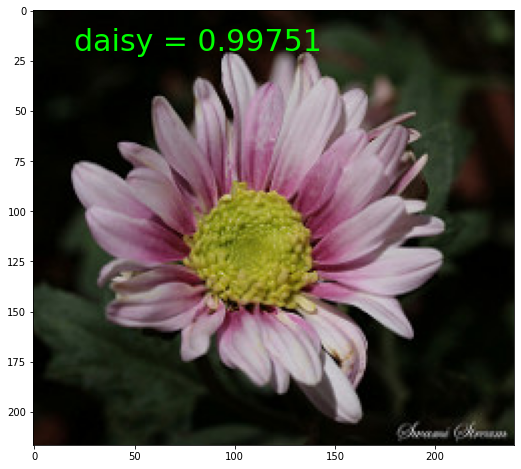

In [58]:
view_image_with_results()

### Example 2

In [59]:
sample_image = os.path.join(test_dir, os.listdir(test_dir)[1])

In [60]:
label, conf_score = get_predictions(sample_image)


Prediction: {'filename': '/tmp/tmp6k7186ay/tmpwvzotygw', 'probs': [0.0009197684703394771, 0.00010226599988527596, 0.9932344555854797, 0.000985586317256093, 0.004757888615131378], 'labels': ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'], 'visualizations': None, 'attributions': None}

Label: roses
Score = 0.9932344555854797

Model prediction: roses with score = 0.9932344555854797

Processing time: 1.0585 seconds


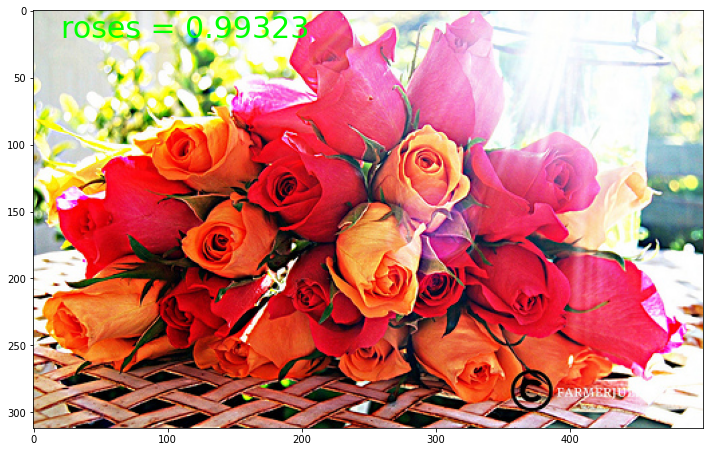

In [61]:
view_image_with_results()

### Example 3

In [62]:
sample_image = os.path.join(test_dir, os.listdir(test_dir)[2])

In [63]:
label, conf_score = get_predictions(sample_image)


Prediction: {'filename': '/tmp/tmpa0c0nlac/tmplmmvyrj4', 'probs': [6.691414455417544e-05, 0.0002513010404072702, 0.0017103650607168674, 0.00021244252275209874, 0.9977589845657349], 'labels': ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'], 'visualizations': None, 'attributions': None}

Label: tulips
Score = 0.9977589845657349

Model prediction: tulips with score = 0.9977589845657349

Processing time: 1.0983 seconds


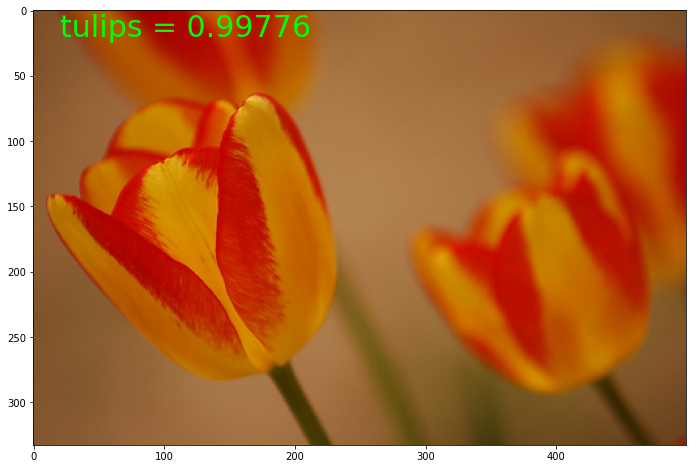

In [64]:
view_image_with_results()

### Generate the Scores and Explanations
- Explainability methods:
   - [XRAI](https://arxiv.org/abs/1906.02825) (xrai)
   - [Integrated Gradients](https://arxiv.org/abs/1703.01365) (integrated_gradients)
   - [Guided GradCAM](https://arxiv.org/abs/1610.02391v4) (guided_gradcam)
   - [Guided BackPropagation](https://arxiv.org/abs/1412.6806) (guided_backprop)

For more details on explainability with AutoML for images, refer to the [generating explanations](https://learn.microsoft.com/en-us/azure/machine-learning/how-to-auto-train-image-models?tabs=python#generate-explanations-for-predictions) and [schema](https://learn.microsoft.com/en-us/azure/machine-learning/reference-automl-images-schema#data-format-for-online-scoring-and-explainability-xai) articles.

In [65]:
# Define explainability (XAI) parameters
model_explainability = True
xai_parameters = {
    "xai_algorithm": "xrai",
    "visualizations": True,
    "attributions": False,
}

# Create request json
request_json = {
    "input_data": {
        "columns": ["image"],
        "data": [
            json.dumps({
                "image_base64":
                base64.encodebytes(read_image(sample_image)).decode("utf-8"),
                "model_explainability":
                model_explainability,
                "xai_parameters":
                xai_parameters,
            })
        ],
    }
}

request_file_name = "sample_request_data_classification.json"

with open(request_file_name, "w") as request_file:
    json.dump(request_json, request_file)
    
resp = ml_client.online_endpoints.invoke(
    endpoint_name=online_endpoint_name,
    deployment_name=deployment.name,
    request_file=request_file_name,
)

predictions = json.loads(resp)

### Visualize Explanations

In [66]:
def base64_to_img(base64_img_str):
    """
    Base64 to image
    """
    base64_img = base64_img_str.encode("utf-8")
    decoded_img = base64.b64decode(base64_img)

    return BytesIO(decoded_img).getvalue()

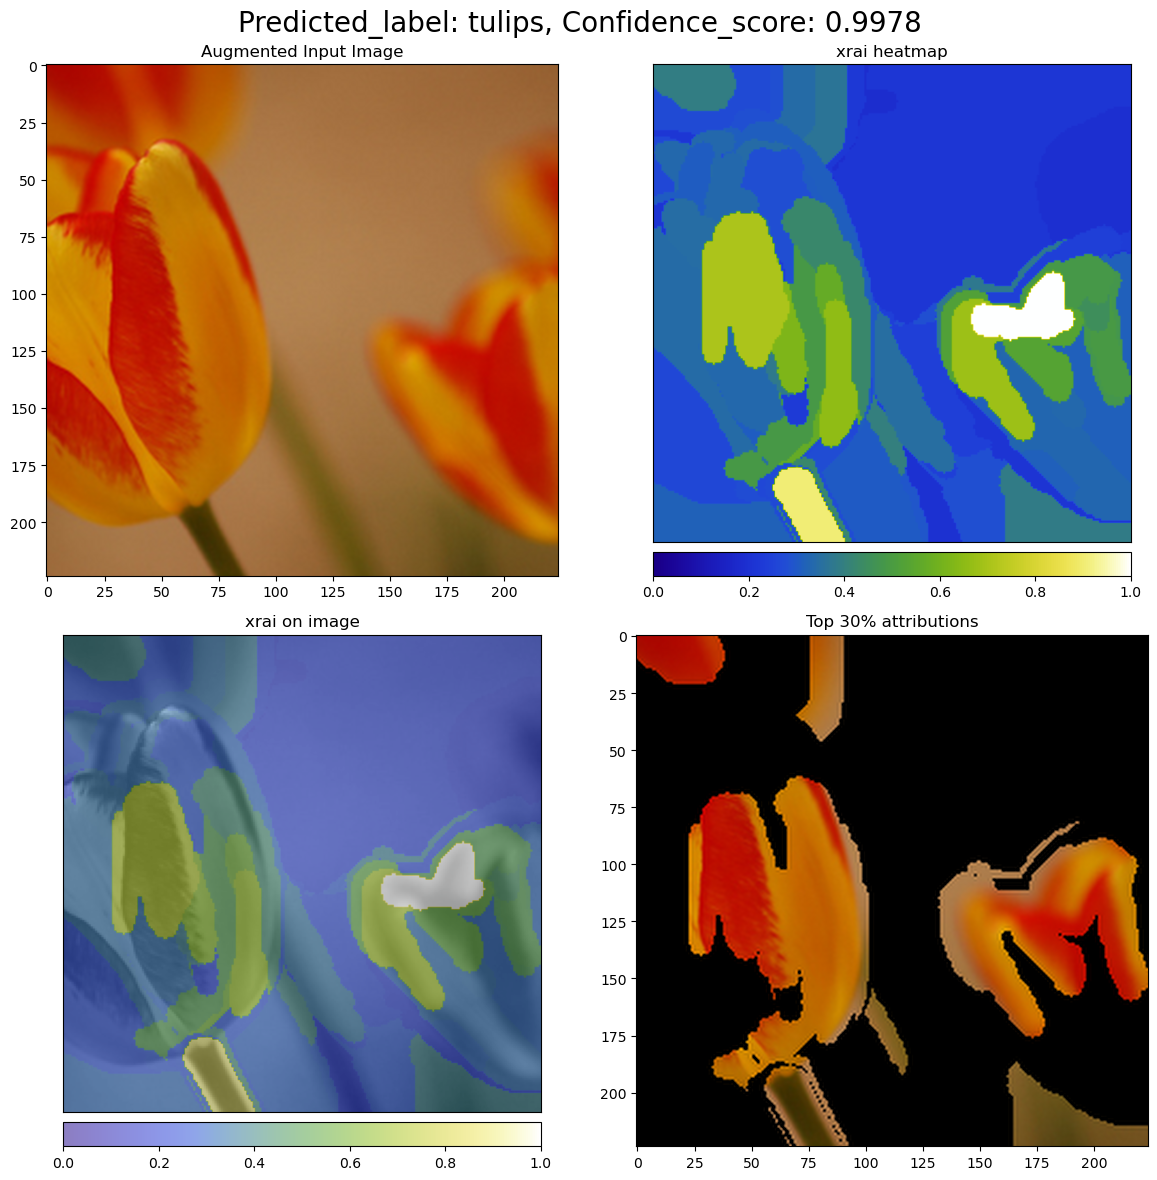

In [67]:
# visualize explanations of the first image against one of the class
img_bytes = base64_to_img(predictions[0]["visualizations"])
image = PILImage.open(BytesIO(img_bytes))

display(image)

### Delete the deployment and endpoint

In [ ]:
print("We can delete the endoint:", online_endpoint_name)

In [ ]:
#ml_client.online_endpoints.begin_delete(name=online_endpoint_name)